# PROYECTO DE CLASIFICACIÓN DE ATAQUES SOBRE DISPOSITIVOS IoT
### Autores:
- Jorge Iraizoz Expósito
- Alejandro Peña Fernández

PD: Se recomienda abrir el proyecto con google colab o con Jupyter Notebook, ya que con visual studio se pierde la salida de alguna celda.

In [1]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# CONJUNTO DE DATOS EMPLEADO:

El conjunto de datos que ha sido empleado, recibe el nomnbre de CiCIoT2023. Este consiste en una serie de capturas de tráfico que contienen tanto tráfico benigno, generado por dispositivos IoT, como tráfico generado por diversos ataques lanzados contra una amplia variedad de estos dispositivos.
Resulta importante destacar que los ataques se han ejecutado desde 4 dispositivos Raspberry-PI y que pueden ser de diversas clases:
- Denegación de servicio (DoS) UDP, HTTP y SYN.
- Denegación de servicio distribuido (DDoS) UDP, HTTP y SYN.
- Escaneo de puertos, escaneo de sistema operativo y descubrimiento de host.

Para generar el dataset, se ha hecho uso de la herramienta tshark. Esta herramienta es realmente útil a la hora de extraer propiedades de los paquetes que forman parte de una captura de tráfico. De cada captura se han extraído 24 propiedades, quedando un fichero de texto con tantas filas como paquetes haya en la captura y con 24 columnas. Este proceso se ha repetido para cada captura y dentro de cada captura, para los paquetes TCP y UDP.

Como último paso para la generación del dataset, se ha implementado un script de python que se encarga de agrupar los paquetes por sesiones (TCP y UDP por separado) y de extraer propiedades adicionales, normalmente std, media, valor mínimo o máximo de las 24 propiedades extraídas en tshark, aunque también se generan nuevas propiedades. El script también se encargará de añadir las etiquetas necesarias (columna category) y de balancear el conjunto de datos equitativamente, respetando la proporción de sesiones UDP y TCP. Nótese que este proceso se ha llevado a cabo para generar 3 conjuntos de datos: Entrenamiento, validación y prueba. El reparto efectuado es del 70%, 10% y 20% respectivamente.

En las siguientes celdas, pueden verse algunas características significativas del conjunto de datos generado.

In [ ]:
os.chdir('C:/Users/boii_/Desktop/TFM/Project')
print("Nuevo directorio actual:", os.getcwd())

Nuevo directorio actual: C:\Users\boii_\Desktop\TFM\Project


In [2]:
ruta_train = 'train.csv'
ruta_val = 'validation.csv'
ruta_test = 'test.csv'

train = pd.read_csv(ruta_train)
validation = pd.read_csv(ruta_val)
test = pd.read_csv(ruta_test)

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
validation=validation.drop(columns = 'Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

## Número de sesiones por clase y por protocolo de la capa de transporte (TCP y UDP):

In [ ]:
print('Train:')
print(train.groupby('proto')['category'].value_counts())
print('\nValidation:')
print(validation.groupby('proto')['category'].value_counts())
print('\nTest:')
print(test.groupby('proto')['category'].value_counts())

Train:
proto  category           
TCP    DoS-SYN_Flood          111730
       DDoS-SYN_Flood         111707
       DoS-HTTP_Flood         110338
       DDoS-HTTP_Flood        108888
       Recon-HostDiscovery    103984
       Recon-PortScan          98923
       Recon-OSScan            94850
       Benign                  30590
       DDoS-UDP_Flood          13810
       DoS-UDP_Flood            2526
UDP    DoS-UDP_Flood          109257
       DDoS-UDP_Flood          97973
       Benign                  81193
       Recon-OSScan            16933
       Recon-PortScan          12860
       Recon-HostDiscovery      7799
       DDoS-HTTP_Flood          2895
       DoS-HTTP_Flood           1445
       DDoS-SYN_Flood             76
       DoS-SYN_Flood              53
Name: count, dtype: int64

Validation:
proto  category           
TCP    DoS-SYN_Flood          15961
       DDoS-SYN_Flood         15958
       DoS-HTTP_Flood         15763
       DDoS-HTTP_Flood        15555
       Recon-Hos

In [6]:
print('Train:')
print(train['category'].value_counts())
print('\nValidation:')
print(validation['category'].value_counts())
print('\nTest:')
print(test['category'].value_counts())

Train:
Benign                 111783
Recon-PortScan         111783
Recon-OSScan           111783
Recon-HostDiscovery    111783
DoS-SYN_Flood          111783
DDoS-HTTP_Flood        111783
DDoS-SYN_Flood         111783
DoS-HTTP_Flood         111783
DoS-UDP_Flood          111783
DDoS-UDP_Flood         111783
Name: category, dtype: int64

Validation:
Benign                 15969
Recon-PortScan         15969
Recon-OSScan           15969
Recon-HostDiscovery    15969
DoS-SYN_Flood          15969
DDoS-HTTP_Flood        15969
DDoS-SYN_Flood         15969
DoS-HTTP_Flood         15969
DoS-UDP_Flood          15969
DDoS-UDP_Flood         15969
Name: category, dtype: int64

Test:
Benign                 31940
Recon-PortScan         31940
Recon-OSScan           31940
Recon-HostDiscovery    31940
DoS-SYN_Flood          31940
DDoS-HTTP_Flood        31940
DDoS-SYN_Flood         31940
DoS-HTTP_Flood         31940
DoS-UDP_Flood          31940
DDoS-UDP_Flood         31940
Name: category, dtype: int64


In [ ]:
#Despliegue de las 5 primeras filas de train.
train.head(5)

,srcport.std,dstport.std,frame.len.min,frame.len.max,frame.len.std,frame.len.mean,frame.len.rate,ip.flags.rb,ip.flags.df,ip.flags.mf,...,tcp.window_size_value.max,tcp.window_size_value.mean,duration,prate,payload.std,payload.min,payload.max,payload.mean,proto,category
0,24356.916631,24356.916631,66.0,317.0,78.648585,93.400000,1912.249362,0.0,1.0,0.0,...,65160.0,9639.200000,0.488430,20.473762,79.157789,0.0,251.0,25.800000,TCP,Benign
1,10511.854410,10511.854410,66.0,1366.0,323.686754,258.871795,247.140244,0.0,1.0,0.0,...,65535.0,3765.564103,40.851299,0.954682,323.932079,0.0,1300.0,192.461538,TCP,Benign
2,0.000000,0.000000,74.0,74.0,0.000000,74.000000,74.109832,0.0,1.0,0.0,...,14600.0,14600.000000,2.995554,1.001484,0.000000,0.0,0.0,0.000000,TCP,Benign
3,29329.598252,29329.598252,66.0,317.0,78.648585,93.400000,1638.619301,0.0,1.0,0.0,...,65160.0,9639.200000,0.569992,17.544104,79.157789,0.0,251.0,25.800000,TCP,Benign
4,27683.632730,27683.632730,66.0,441.0,126.803479,124.700000,2963.685350,0.0,1.0,0.0,...,65160.0,9639.200000,0.420760,23.766522,127.556915,0.0,375.0,57.100000,TCP,Benign


In [7]:
print(f'Train shape: {train.shape}')
print(f'Validation shape: {validation.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1117830, 57)
Validation shape: (159690, 57)
Test shape: (319400, 57)


In [ ]:
train.describe()

,srcport.std,dstport.std,frame.len.min,frame.len.max,frame.len.std,frame.len.mean,frame.len.rate,ip.flags.rb,ip.flags.df,ip.flags.mf,...,tcp.window_size_value.std,tcp.window_size_value.min,tcp.window_size_value.max,tcp.window_size_value.mean,duration,prate,payload.std,payload.min,payload.max,payload.mean
count,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1117830.0,1.117830e+06,1117830.0,...,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06,1.117830e+06
mean,1.395758e+04,1.395758e+04,6.924559e+01,2.073510e+02,4.082560e+01,9.175789e+01,6.171146e+04,0.0,3.452455e-01,0.0,...,8.446193e+03,1.278543e+03,1.638861e+04,7.038688e+03,2.744101e+02,7.380399e+02,3.964369e+01,1.412430e+01,1.500117e+02,3.536978e+01
std,1.479939e+04,1.479939e+04,3.428272e+01,6.683602e+02,1.484783e+02,9.668522e+01,3.345829e+06,0.0,4.354916e-01,0.0,...,1.547878e+04,7.605421e+03,2.624921e+04,1.306917e+04,3.387628e+03,2.296659e+04,1.489123e+02,4.040055e+01,6.672854e+02,9.780914e+01
min,0.000000e+00,0.000000e+00,6.000000e+01,6.000000e+01,0.000000e+00,6.000000e+01,0.000000e+00,0.0,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,6.000000e+01,6.000000e+01,0.000000e+00,6.000000e+01,8.745543e-02,0.0,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.137363e-03,8.575225e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.520788e+03,7.520788e+03,6.000000e+01,6.000000e+01,0.000000e+00,6.000000e+01,3.251918e+02,0.0,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,1.024000e+03,5.120000e+02,1.063831e-01,4.589166e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.741312e+04,2.741312e+04,6.000000e+01,7.800000e+01,9.899495e+00,7.400000e+01,2.482265e+03,0.0,1.000000e+00,0.0,...,7.220000e+03,5.120000e+02,2.920000e+04,6.961167e+03,6.301872e-01,2.993473e+01,0.000000e+00,8.000000e+00,2.800000e+01,2.000000e+01
max,4.629145e+04,4.629145e+04,1.514000e+03,3.626600e+04,2.831508e+03,2.828300e+03,1.631584e+09,0.0,1.000000e+00,0.0,...,4.634024e+04,6.553500e+04,6.553500e+04,6.553500e+04,9.186004e+04,4.194304e+06,2.831733e+03,2.419000e+03,3.620000e+04,2.773100e+03


In [8]:
#Cambiamos los valores de la columna "proto" a valores numéricos.
train['proto'].replace({'TCP': 0, 'UDP': 1}, inplace=True)
validation['proto'].replace({'TCP': 0, 'UDP': 1}, inplace=True)
test['proto'].replace({'TCP': 0, 'UDP': 1}, inplace=True)

In [9]:
X_train = train.drop(columns=['category'])
y_train = train['category']

X_val = validation.drop(columns=['category'])
y_val = validation['category']

X_test = test.drop(columns=['category'])
y_test = test['category']

# IMPLEMENTACIÓN DEL CLASIFICADOR RANDOM FOREST:
Random Forest es un algoritmo de machine learning de uso común que combina la salida de varios árboles de decisiones para alcanzar un resultado único. Su facilidad de uso y su flexibilidad a la hora de manejar este tipo de conjuntos de datos ha sido una motivación para emplearlo en este proyecto, ya que suele ofrecer buenos resultados en este tipo de clasifiaciones.

In [ ]:
RF = RandomForestClassifier()

start=time.time()
RF.fit(X_train, y_train)
stop=time.time()

tiempo = stop - start

print('Tiempo de entrenamiento RF: ', tiempo)

start1=time.time()
print(f'Validation accuracy : {RF.score(X_val, y_val): .3f}')
stop1=time.time()

tiempo1 = stop1 - start1
print(f"Tiempo de prediccion RF: {tiempo1}s")


start2=time.time()
print(f'Test accuracy : {RF.score(X_test, y_test): .3f}')
stop2=time.time()

tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) RF: {tiempo2}s")

Tiempo de entrenamiento RF:  765.3411402702332
Validation accuracy :  0.872
Tiempo de prediccion RF: 8.651836633682251s
Test accuracy :  0.872
Tiempo de prediccion (Test) RF: 15.0159592628479s


In [ ]:
import joblib

#joblib.dump(RF, 'model_RF.pkl')

In [ ]:
#Load Random Forest model
RF_P = joblib.load('/content/drive/My Drive/ProyectoPASM/Proyecto_balanceado/model_RF.pkl')

In [ ]:
y_proba = RF_P.predict_proba(X_val)
labels = y_val

## MATRIZ DE CONFUSIÓN CONJUNTO DE VALIDACIÓN:

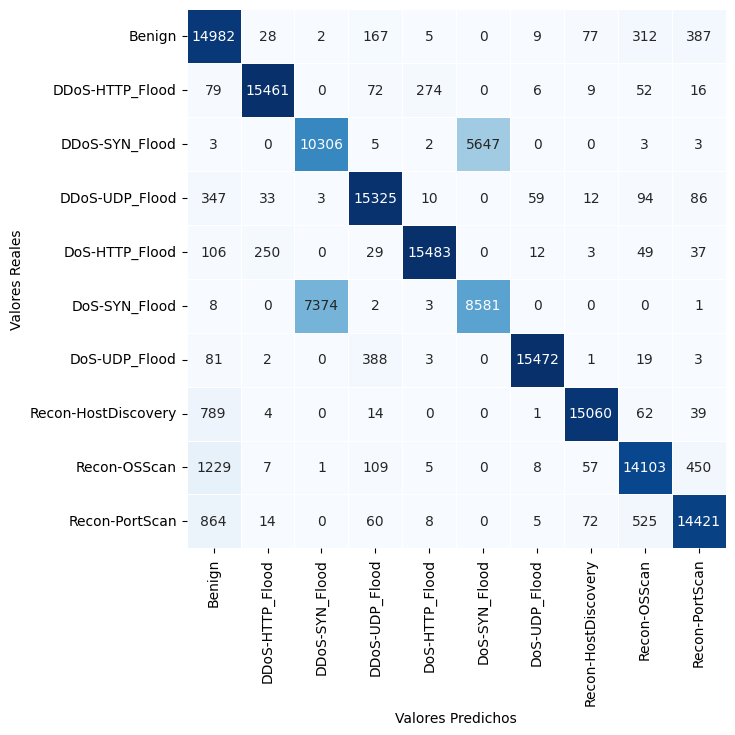

In [ ]:
y_pred_RF1 = RF_P.predict(X_val)
cm = metrics.confusion_matrix(y_val, y_pred_RF1)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

## MATRIZ DE CONFUSIÓN CONJUNTO DE PRUEBA:

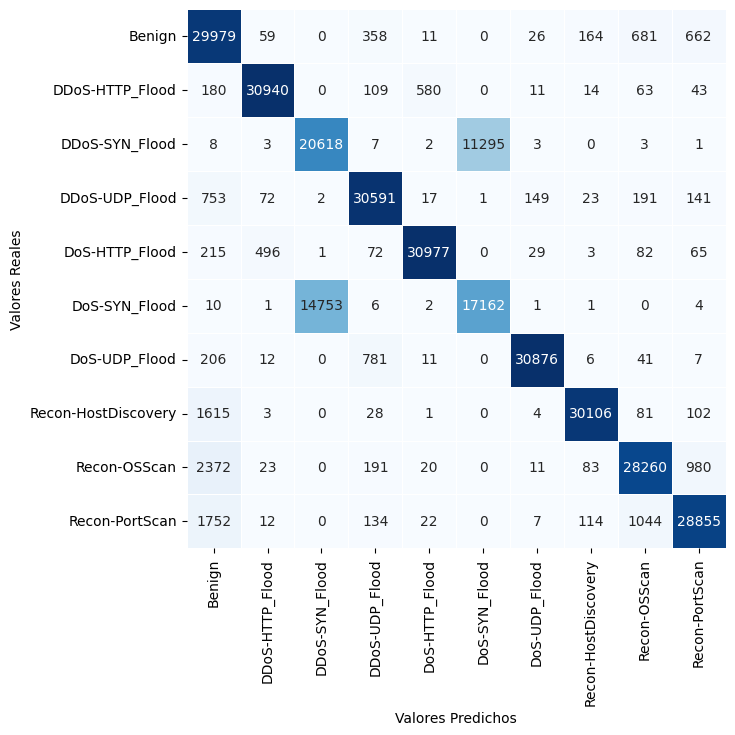

In [ ]:
y_pred_RF2 = RF_P.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF2)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Como se puede observar, tanto para el conjunto de validación como para el conjunto de prueba, las matrices de confusión arrojan unos resultados aceptables. Puede observarse que en ambos conjuntos los paquetes de DoS-SYN_Flood y DDoS-SYN_Flood no se clasificán con mucho éxito. Se aprecia que el clasficiador presenta problemas a la hora de clasificar este tipo de ataques por su gran similitud y, por tanto, los confunde entre sí pero muy pocas veces con otro tipo de clase.

## CURVAS FAR y FRR:

In [ ]:
genuinos = []
impostores = []

for i in range(len(y_val)):
    # Obtener la etiqueta real del dato actual
    etiqueta_real = y_val[i]

    # Obtener el índice de la clase genuina correspondiente a la etiqueta real
    indice_genuino = np.where(RF_P.classes_ == etiqueta_real)[0][0]

    # Obtener el score genuino y los scores impostores para el dato actual
    score_genuino = y_proba[i][indice_genuino]
    scores_impostores = np.delete(y_proba[i], indice_genuino)

    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)


genuinos = np.array(genuinos)
impostores = np.array(impostores)

print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)


Genuinos: (159690,)
Impostores: (1437210,)


In [ ]:
# Calcular la FAR y la FRR
thresholds = np.arange(-0.001, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos <= threshold) / len(genuinos))

# Imprimir FAR, FRR
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [1.0, 1.0, 0.09821598792104146, 0.09820833420307401, 0.09820207207019155, 0.09819789731493658, 0.09815962872509933, 0.09815336659221686, 0.098133884401027, 0.0981331886084845, 0.0981317970233995, 0.0981317970233995, 0.07620876559445036, 0.07620598242428038, 0.07620389504665288, 0.0762031992541104, 0.07619693712122794, 0.07619276236597296, 0.07619206657343047, 0.07619206657343047, 0.07619206657343047, 0.07619206657343047, 0.06595000034789628, 0.06594860876281128, 0.06594860876281128, 0.06594860876281128, 0.0659465213851838, 0.0659451298000988, 0.06594443400755631, 0.06594443400755631, 0.06594443400755631, 0.06594165083738633, 0.0593156184552014, 0.059312835285031416, 0.059307964737233945, 0.059307964737233945, 0.059305181567063964, 0.05930448577452147, 0.05930448577452147, 0.05930448577452147, 0.05930378998197897, 0.05930309418943648, 0.05437131664822816, 0.05437131664822816, 0.05437131664822816, 0.05436853347805818, 0.05436783768551569, 0.054362271345175725, 0.054362271345175725, 

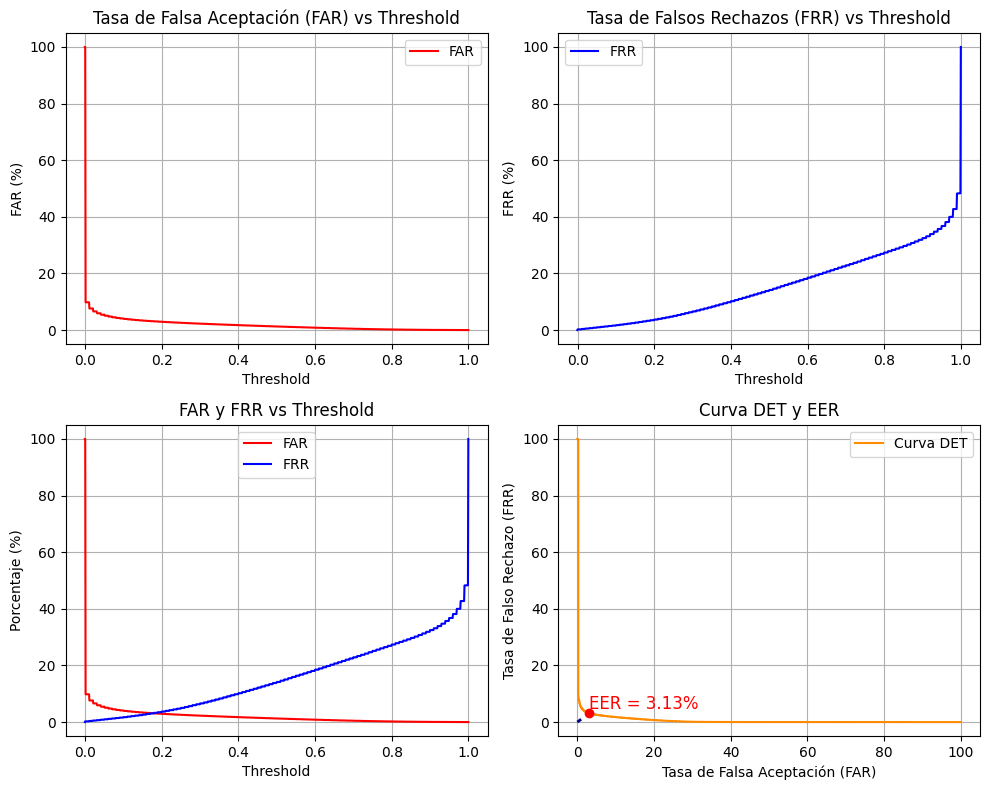

In [ ]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.absolute((np.array(FAR_porcentaje) - np.array(FRR_porcentaje))))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Graficar FAR vs Threshold
axs[0, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('FAR (%)')
axs[0, 0].set_title('Tasa de Falsa Aceptación (FAR) vs Threshold')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Graficar FRR vs Threshold
axs[0, 1].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[0, 1].set_xlabel('Threshold')
axs[0, 1].set_ylabel('FRR (%)')
axs[0, 1].set_title('Tasa de Falsos Rechazos (FRR) vs Threshold')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Graficar FAR y FRR juntas
axs[1, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[1, 0].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('Porcentaje (%)')
axs[1, 0].set_title('FAR y FRR vs Threshold')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Graficar Curva DET
axs[1, 1].plot(FRR_porcentaje, FAR_porcentaje, color='darkorange', label='Curva DET')
axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1, 1].scatter([eer], [eer], color='red', zorder=5)
axs[1, 1].text(eer, eer, f'EER = {eer:.2f}%', color='red', fontsize=12, verticalalignment='bottom')
axs[1, 1].set_xlabel('Tasa de Falsa Aceptación (FAR)')
axs[1, 1].set_ylabel('Tasa de Falso Rechazo (FRR)')
axs[1, 1].set_title('Curva DET y EER')
axs[1, 1].grid(True)
axs[1, 1].legend(loc="upper right")

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()



Tras realizar un estudio y calcular las FAR, FRR, DET y EER se han obtenido las anteriores gráficas las cuales dan una información relevante sobre donde fijar el umbral del clasificador a la hora de aceptar una prueba o de rechazarla.

## CURVA ROC

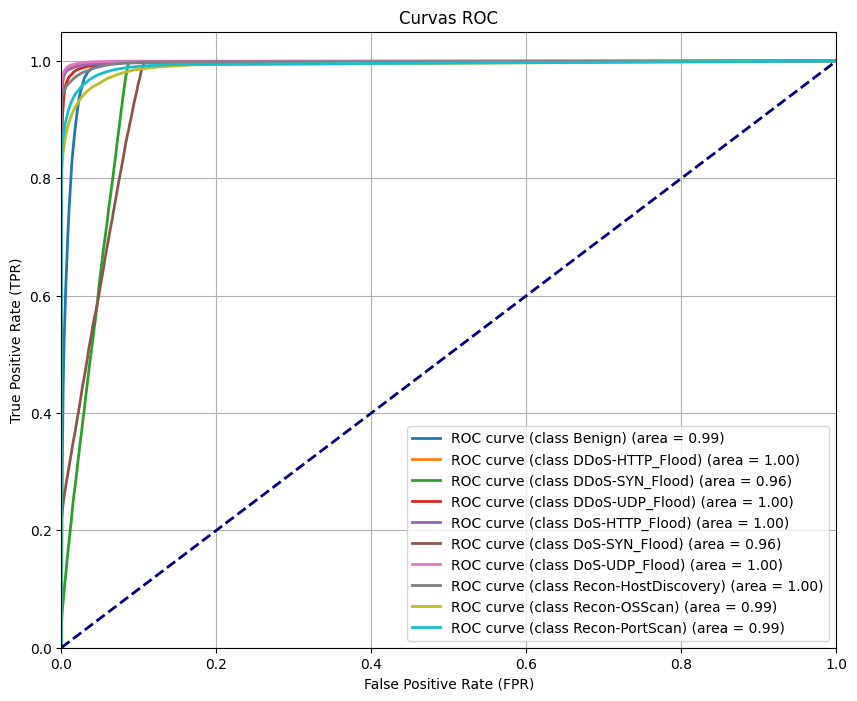

In [ ]:
y_pred_prob = RF_P.predict_proba(X_val)

# Binarizar las etiquetas
from sklearn.preprocessing import label_binarize
classes = np.unique(y_val)
y_val_bin = label_binarize(y_val, classes=classes)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'ROC curve (class {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Se han calculado las curvas ROC para reflejar el diagnóstico de cuales presentan una mejor clasificación en el sistema.

# NORMALIZACIÓN DEL CONJUNTO DE DATOS:
La normalización es una técnica de pre-procesamiento de datos que se utiliza para ajustar las características o atributos de los datos dentro de un rango específico y mejorar su interpretación. Por lo tanto, la normalización es un proceso esencial en la ciencia de datos y el aprendizaje automático que se utiliza para mejorar la eficiencia y la precisión de los algoritmos.

Cabe recalcar que, aunque en la mayoría de ocasiones la normalización mejore el rendimiento, no siempre es necesario normalizar. Sin embargo, por la forma de los datos de este proyecto, sí que ha sido necesario. Nótese que solo se necesita normalizar para el entrenamiento de SVM y de las redes neuronales, ya que si no, los resultados ofrecidos eran bastante pobres.

In [ ]:
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_val = norm.fit_transform(X_val)
X_test = norm.fit_transform(X_test)

# SVM
Support vector machine (SVM) es un algoritmo de aprendizaje supervisado que se utiliza en muchos problemas de clasificación y regresión.
SVM funciona correlacionando datos a un espacio de características de grandes dimensiones de forma que los puntos de datos se puedan categorizar, incluso si los datos no se puedan separar linealmente de otro modo.

## REDUCCIÓN DEL CONJUNTO DE DATOS:
Dado que el conjunto de datos es demasiado extenso y tiene muchas características (57), a SVM le resulta muy costoso, computacionalmente hablando, entrenarse con todas ellas. Es por este motivo que se ha decidido entrenar y validar SVM con un 1% de las muestras totales de cada conjunto de datos. Eso si, siempre respetando la proporción de sesiones UDP y TCP que haya de cada clase.

In [20]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [4]:
ruta_train = 'train.csv'
ruta_val = 'validation.csv'
ruta_test = 'test.csv'

train = pd.read_csv(ruta_train)
validation = pd.read_csv(ruta_val)
test = pd.read_csv(ruta_test)

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
validation=validation.drop(columns = 'Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

In [5]:
porcentaje_mantener = 0.001


train_reducido_udp = train[train['proto'] == 'UDP'].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 'TCP'].groupby('category').sample(frac=porcentaje_mantener)

train_reducido = pd.concat([train_reducido_udp, train_reducido_tcp])

validation_reducido_udp = validation[validation['proto'] == 'UDP'].groupby('category').sample(frac=porcentaje_mantener)
validation_reducido_tcp = validation[validation['proto'] == 'TCP'].groupby('category').sample(frac=porcentaje_mantener)

validation_reducido = pd.concat([validation_reducido_udp, validation_reducido_tcp])

test_reducido_udp = test[test['proto'] == 'UDP'].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 'TCP'].groupby('category').sample(frac=porcentaje_mantener)

test_reducido = pd.concat([test_reducido_udp, test_reducido_tcp])

In [4]:
train_reducido['category'].value_counts()

category
Benign                 112
DDoS-HTTP_Flood        112
DDoS-UDP_Flood         112
DoS-UDP_Flood          112
Recon-HostDiscovery    112
Recon-OSScan           112
DDoS-SYN_Flood         112
Recon-PortScan         112
DoS-SYN_Flood          112
DoS-HTTP_Flood         111
Name: count, dtype: int64

In [6]:
train_reducido['proto'] = train_reducido['proto'].map({'TCP': 0, 'UDP': 1})
validation_reducido['proto'] = validation_reducido['proto'].map({'TCP': 0, 'UDP': 1})
test_reducido['proto'] = test_reducido['proto'].map({'TCP': 0, 'UDP': 1})

In [7]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train_reducido = train_reducido.drop(columns=['category'])
y_train_reducido = train_reducido['category']

# Separar características y etiquetas para conjunto de validación
X_val_reducido = validation_reducido.drop(columns=['category'])
y_val_reducido = validation_reducido['category']

# Separar características y etiquetas para conjunto de prueba
X_test_reducido = test_reducido.drop(columns=['category'])
y_test_reducido = test_reducido['category']

In [8]:
#Normalización del conjunto de datos reducido
norm = StandardScaler()

X_train_reducido = norm.fit_transform(X_train_reducido)
X_val_reducido = norm.fit_transform(X_val_reducido)
X_test_reducido = norm.fit_transform(X_test_reducido)

In [10]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_reducido, y_train_reducido)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_reducido, y_test_reducido))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(20.1)}
Best Cross Validation Score: 0.6263613068545804
Test Score: 0.6625


In [17]:
SVM =  grid.best_estimator_
y_pred = SVM.predict(X_test_reducido)
print('Precision en test: ', accuracy_score(y_test_reducido, y_pred))

Precision en test:  0.6625


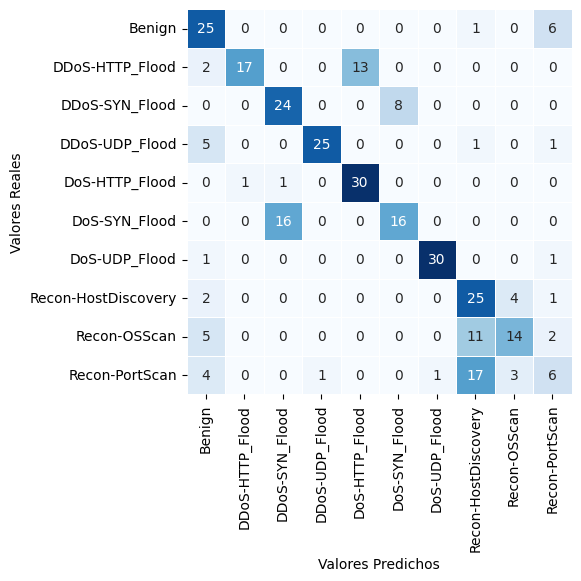

In [21]:
cm1 = confusion_matrix(y_test_reducido, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [15]:
SVM = svm.SVC(kernel='rbf')#, C=1, gamma='auto')

start=time.time()
SVM.fit(X_train_reducido, y_train_reducido)
stop=time.time()

tiempo = stop - start

print(f"Tiempo de entrenamiento SVM: {tiempo}s")
print(f'Train accuracy : {SVM.score(X_train_reducido, y_train_reducido): .3f}')

start1=time.time()
print(f'Validation accuracy : {SVM.score(X_val_reducido, y_val_reducido): .3f}')
stop1=time.time()

tiempo1 = stop1 - start1
print(f"Tiempo de prediccion SVM: {tiempo1}s")


start2=time.time()
print(f'Test accuracy : {SVM.score(X_test_reducido, y_test_reducido): .3f}')
stop2=time.time()

tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) SVM: {tiempo2}s")

Tiempo de entrenamiento SVM: 0.04425239562988281s
Train accuracy :  0.658
Validation accuracy :  0.594
Tiempo de prediccion SVM: 0.009079694747924805s
Test accuracy :  0.622
Tiempo de prediccion (Test) SVM: 0.017508268356323242s


In [ ]:
#Guardar modelo con Joblib
import joblib

joblib.dump(SVM, 'model_SVM.pkl')

['model_SVM.pkl']

In [9]:
y_pred_SVM_val = SVM.predict(X_val_reducido)

In [10]:
y_pred_SVM_test = SVM.predict(X_test_reducido)

In [11]:
accuracy_val = accuracy_score(y_val_reducido, y_pred_SVM_val)
print(f"Validation accuracy: {accuracy_val: .3f}")

accuracy_test = accuracy_score(y_test_reducido, y_pred_SVM_test)
print(f"Test accuracy: {accuracy_test: .3f}")

Validation accuracy:  0.533
Test accuracy:  0.767


## MATRIZ DE CONFUSIÓN (VALIDACIÓN):

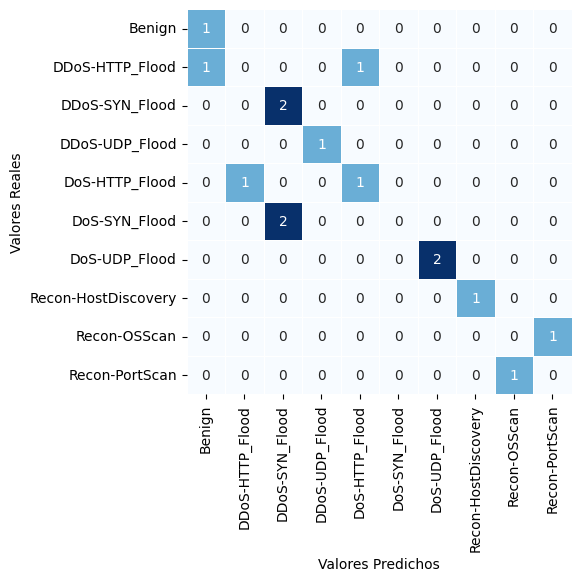

In [12]:
cm1 = metrics.confusion_matrix(y_val_reducido, y_pred_SVM_val)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

## MATRIZ DE CONFUSIÓN (TEST):

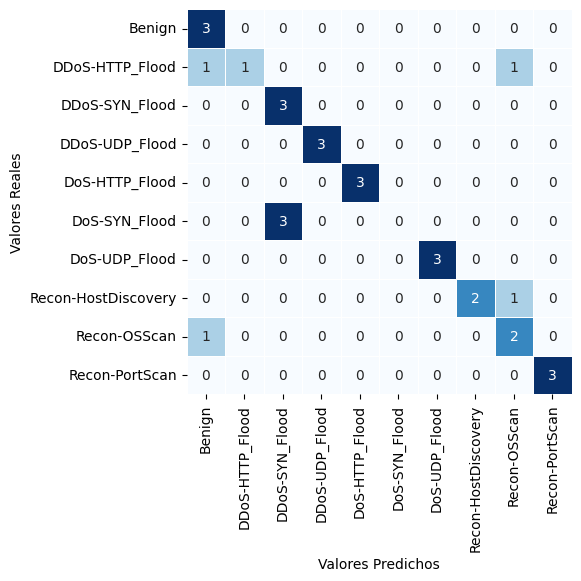

In [13]:
cm2 = metrics.confusion_matrix(y_test_reducido, y_pred_SVM_test)
normalized_matrix = cm2 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Al observar las matrices de confusión, se aprecia que para el algoritmo SVM la precisión ha bajado, ya que este no consigue clasificar con tanto éxito las diferentes sesiones. Por el coste de computación que presenta SVM se ha tenido que reducir mucho el conjunto de datos para poder realizar las pruebas.
En este caso, no solo presenta errores al clasificar las sesiones SYN, si no que también presenta errores al clasificar las denegaciones de servicio de paquetes HTTP y los ataques de reconocimiento.

In [ ]:
# Predicción de valores de validacion
y_score = SVM.decision_function(X_val_reducido)
labels = y_val_reducido

In [ ]:
# Restablecimiento del índice
y_val_reducido = y_val_reducido.reset_index(drop=True)

0    Benign
1    Benign
2    Benign
3    Benign
4    Benign
Name: category, dtype: object


In [ ]:
genuinos = []
impostores = []

for i in range(len(y_val_reducido)):
    # Obtener la etiqueta real del dato actual
    etiqueta_real = y_val_reducido[i]

    # Obtener el índice de la clase genuina correspondiente a la etiqueta real
    indice_genuino = np.where(SVM.classes_ == etiqueta_real)[0][0]

    # Obtener el score genuino y los scores impostores para el dato actual
    score_genuino = y_score[i][indice_genuino]
    scores_impostores = np.delete(y_score[i], indice_genuino)

    # Agregar los scores a los arrays correspondientes
    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)


genuinos = np.array(genuinos)
impostores = np.array(impostores)

print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)

Genuinos: (1599,)
Impostores: (14391,)


In [ ]:
# Calcular la FAR y la FRR
thresholds = np.arange(0, 10.01, 0.01)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos < threshold) / len(genuinos))

# Imprimir FAR, FRR
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.8981307761795567, 0.898130776179

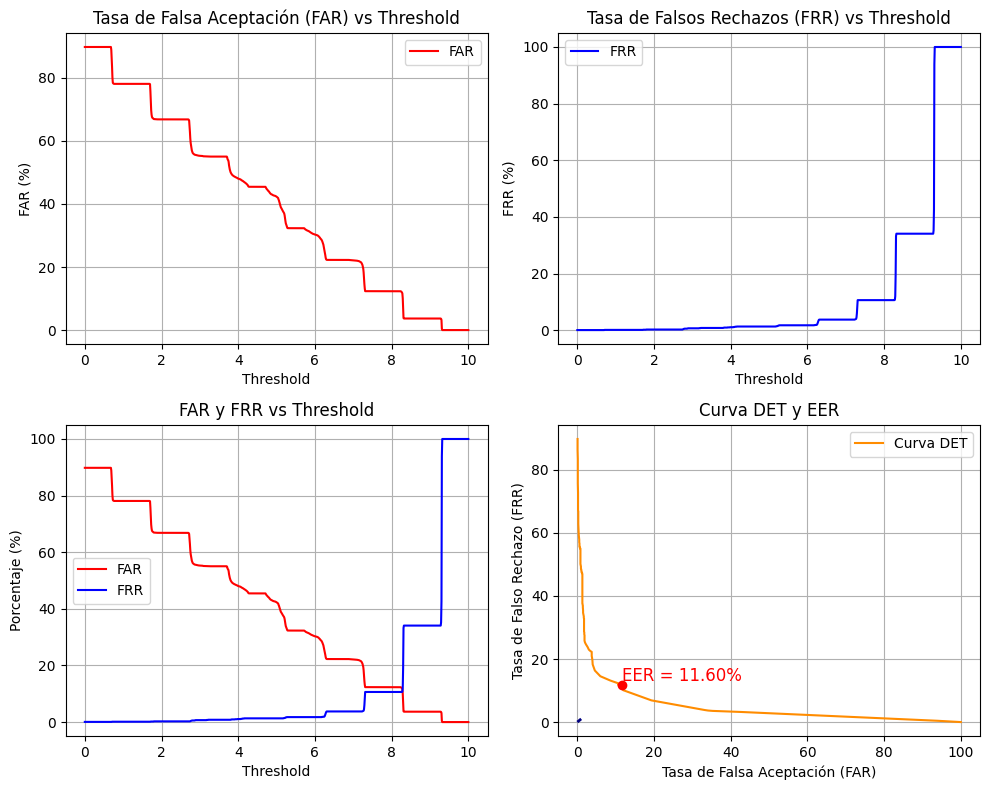

In [ ]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.absolute((np.array(FAR_porcentaje) - np.array(FRR_porcentaje))))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Graficar FAR vs Threshold
axs[0, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('FAR (%)')
axs[0, 0].set_title('Tasa de Falsa Aceptación (FAR) vs Threshold')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Graficar FRR vs Threshold
axs[0, 1].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[0, 1].set_xlabel('Threshold')
axs[0, 1].set_ylabel('FRR (%)')
axs[0, 1].set_title('Tasa de Falsos Rechazos (FRR) vs Threshold')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Graficar FAR y FRR juntas
axs[1, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[1, 0].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('Porcentaje (%)')
axs[1, 0].set_title('FAR y FRR vs Threshold')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Graficar Curva DET
axs[1, 1].plot(FRR_porcentaje, FAR_porcentaje, color='darkorange', label='Curva DET')
axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1, 1].scatter([eer], [eer], color='red', zorder=5)
axs[1, 1].text(eer, eer, f'EER = {eer:.2f}%', color='red', fontsize=12, verticalalignment='bottom')
axs[1, 1].set_xlabel('Tasa de Falsa Aceptación (FAR)')
axs[1, 1].set_ylabel('Tasa de Falso Rechazo (FRR)')
axs[1, 1].set_title('Curva DET y EER')
axs[1, 1].grid(True)
axs[1, 1].legend(loc="upper right")

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()



# CURVA ROC

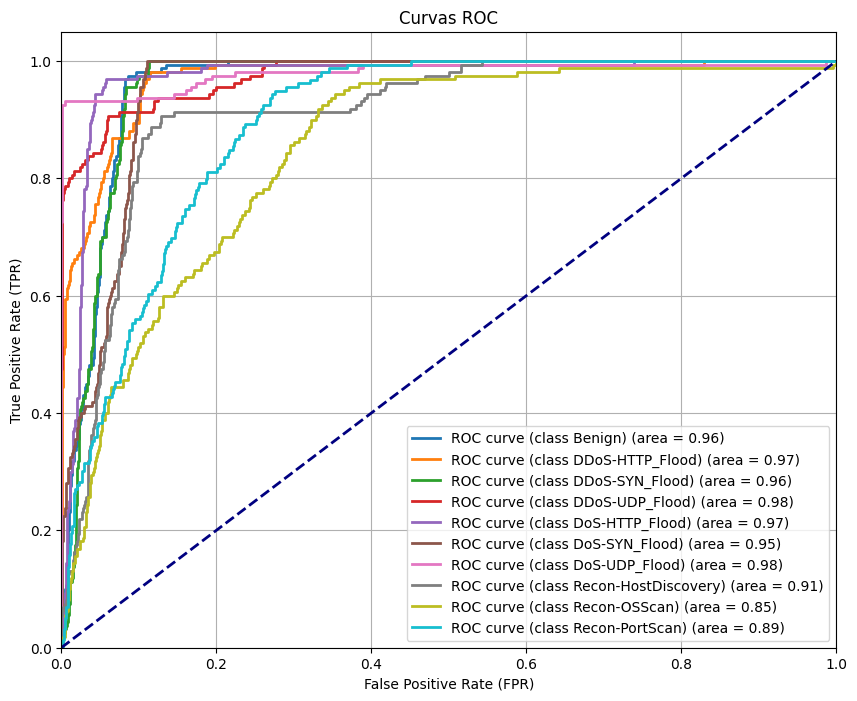

In [ ]:
y_score = SVM.decision_function(X_val_reducido)

# Binarizar las etiquetas
from sklearn.preprocessing import label_binarize
classes = np.unique(y_val_reducido)
y_val_bin = label_binarize(y_val_reducido, classes=classes)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'ROC curve (class {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


En este apartado se han calculado las curvas ROC de igual manera que se ha hecho para el algoritmo RF. Para SVM se aprecia que las curvas son peores, esto se debe a que tiene peor presición que RF.

# PERCEPTRÓN MULTICAPA
El perceptrón multicapa se utiliza para resolver problemas de asociación de patrones, segmentación de imágenes, compresión de datos, etc. Debido a la forma de los datos de este proyecto se ha decidido implementarlo para comprobar su rendimiento.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [11]:
# Normalización del conjunto de datos
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_val = norm.fit_transform(X_val)
X_test = norm.fit_transform(X_test)

In [12]:
#Codificacion de etiquetas (Numéricas)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
y_val_encoded = label_encoder.transform(y_val)


# Convertir las etiquetas codificadas a codificación one-hot (10 columnas por muestras)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=10)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=10)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=10)

In [14]:
model_filepath = 'Model2/model2-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    #verbose = 1
)

In [15]:
# Definir el modelo de la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch = 50
steps_per_epoch = len(X_train) // batch
validation_steps = len(X_val) // batch

# Entrenar el modelo
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=40, batch_size=batch,
                    validation_data=(X_val, y_val_one_hot),
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks=[checkpoint])



Epoch 1/40


22356/22356 [==============================] - 48s 2ms/step - loss: 0.6551 - accuracy: 0.7039 - val_loss: 0.6024 - val_accuracy: 0.7342
Epoch 2/40
22356/22356 [==============================] - 48s 2ms/step - loss: 0.5747 - accuracy: 0.7407 - val_loss: 0.5667 - val_accuracy: 0.7477
Epoch 3/40
22356/22356 [==============================] - 48s 2ms/step - loss: 0.5506 - accuracy: 0.7510 - val_loss: 0.5448 - val_accuracy: 0.7562
Epoch 4/40
22356/22356 [==============================] - 48s 2ms/step - loss: 0.5348 - accuracy: 0.7580 - val_loss: 0.5321 - val_accuracy: 0.7633
Epoch 5/40
22356/22356 [==============================] - 48s 2ms/step - loss: 0.5240 - accuracy: 0.7632 - val_loss: 0.5281 - val_accuracy: 0.7646
Epoch 6/40
22356/22356 [==============================] - 48s 2ms/step - loss: 0.5141 - accuracy: 0.7668 - val_loss: 0.5729 - val_accuracy: 0.7295
Epoch 7/40
22356/22356 [==============================] - 48s 2ms/step - loss: 0.5087 - accuracy: 0.7690 - val_los

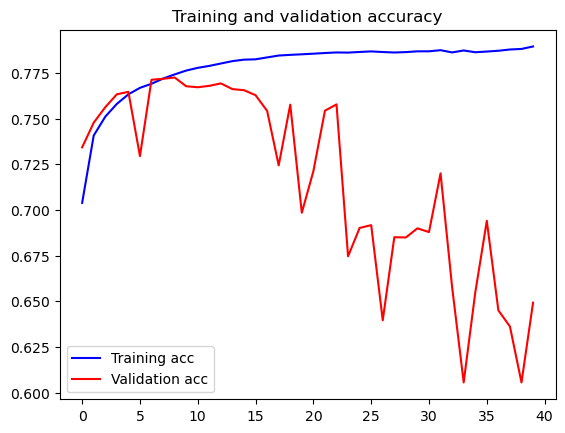

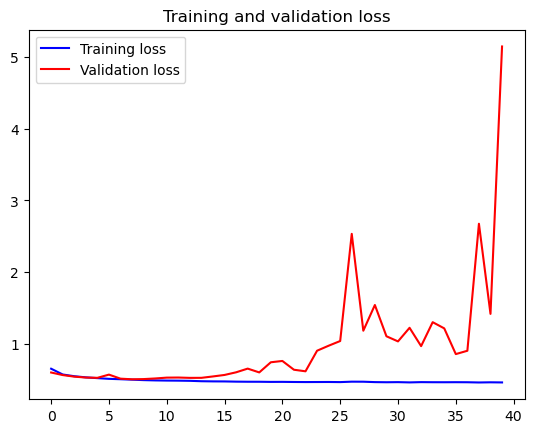

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Importamos el modelo con mayor accuracy en validacion
MLP1 = load_model('/content/drive/My Drive/ProyectoPASM/Proyecto_balanceado/Model2/model2-10-0.7747.keras')

# MATRIZ DE CONFUSIÓN

In [ ]:
y_pred_proba = MLP1.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

9982/9982 [==============================] - 84s 8ms/step


In [ ]:
# Calcular la precisión
accuracy = accuracy_score(y_test_encoded, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7572949279899812


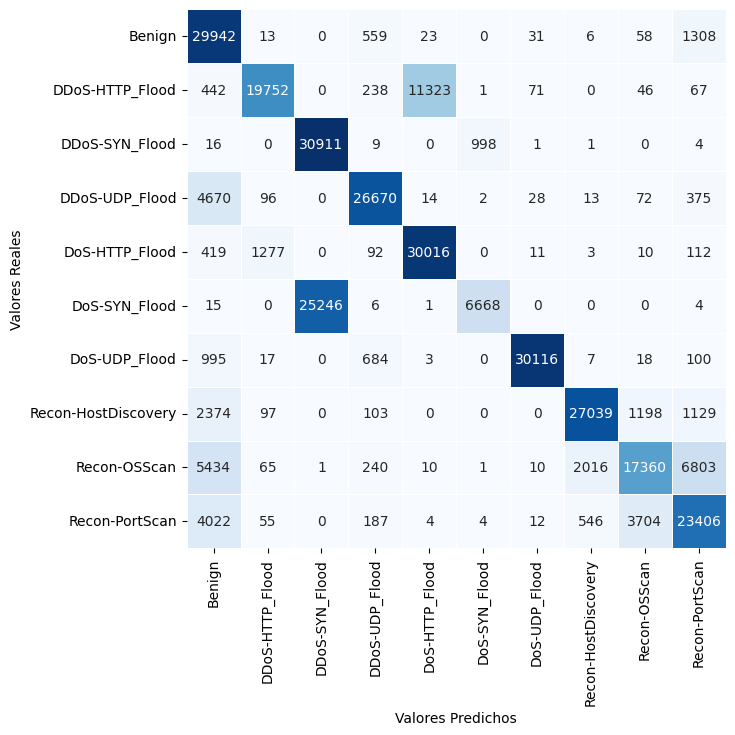

In [ ]:
cm = metrics.confusion_matrix(y_test_encoded, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

En las primeras gráficas, las cuales reflejan la precisión y pérdidas del sistema en el conjunto de train y de validación, se observa que en el entrenamiento se ha llegado a un valor de un 80% de precisión, sin embargo para el de validación este valor ha caido bruscamente hasta un 62%. A modo de comprobación se ha calculado la matriz de confusión y, como se ha atisbado con anteriormente, este sistema no ha clasificado con mucho éxito los datos. Nótese que los errores son similares a los acontecidos en la anterior clasificación, aunque esta vez los resultados arrojados son algo mejores.

## CURVAS FAR, FRR Y EER

In [ ]:
# Inicializar arrays para almacenar los scores genuinos e impostores
genuinos = []
impostores = []

# Iterar sobre cada dato de prueba
for i in range(len(y_test_encoded)):
    # Obtener la etiqueta real del dato actual
    etiqueta_real = y_test_encoded[i]

    # Obtener las probabilidades predichas para el dato actual
    prob_predicha = y_pred_proba[i]

    # Obtener el score genuino para la clase real
    score_genuino = prob_predicha[etiqueta_real]


    scores_impostores = np.delete(prob_predicha, etiqueta_real)

    # Agregar los scores a los arrays correspondientes
    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)

# Convertir a arrays numpy para facilitar el manejo
genuinos = np.array(genuinos)
impostores = np.array(impostores)

# Verificar la forma de los arrays resultantes
print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)

Genuinos: (319400,)
Impostores: (2874600,)


In [ ]:
# Calcular la FAR y la FRR
thresholds = np.arange(0, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos < threshold) / len(genuinos))

# Imprimir FAR, FRR y AUC
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [1.0, 0.20803798789396785, 0.19383079384957907, 0.18474987824392958, 0.17822131774855632, 0.17290997008279413, 0.1682331454811104, 0.16338168788701038, 0.15977005496416893, 0.1563942809434356, 0.15295380226814165, 0.15002643846100328, 0.14693453002156823, 0.144106658317679, 0.1418058164614207, 0.1395742016280526, 0.13751234954428443, 0.13590725666179643, 0.13441313574062477, 0.13318548667640714, 0.13207228831837473, 0.13115494329645863, 0.13023794614902942, 0.12936652055938216, 0.12852779517150212, 0.12770750713142698, 0.12684060391010923, 0.12603144785361442, 0.1250535726709803, 0.1239636819035692, 0.12292040631740069, 0.12194253113476658, 0.12091595352396856, 0.1199812147777082, 0.11912996590830029, 0.11832637584359564, 0.11762923537187783, 0.1169327906491338, 0.11628330898211925, 0.11566722326584568, 0.11500278299589509, 0.11431155639045433, 0.11363424476448897, 0.11299380783413344, 0.11239789883809921, 0.11179364085437973, 0.1112050372225701, 0.11066130939956864, 0.11010575384

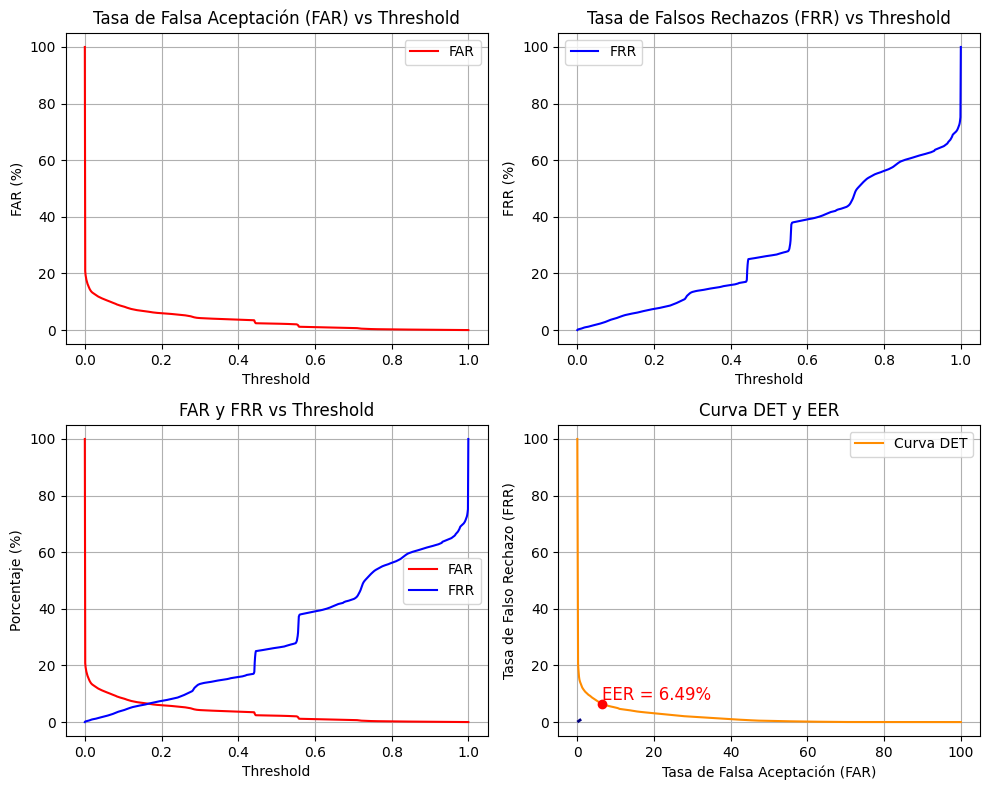

In [ ]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.absolute((np.array(FAR_porcentaje) - np.array(FRR_porcentaje))))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Graficar FAR vs Threshold
axs[0, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('FAR (%)')
axs[0, 0].set_title('Tasa de Falsa Aceptación (FAR) vs Threshold')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Graficar FRR vs Threshold
axs[0, 1].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[0, 1].set_xlabel('Threshold')
axs[0, 1].set_ylabel('FRR (%)')
axs[0, 1].set_title('Tasa de Falsos Rechazos (FRR) vs Threshold')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Graficar FAR y FRR juntas
axs[1, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[1, 0].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('Porcentaje (%)')
axs[1, 0].set_title('FAR y FRR vs Threshold')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Graficar Curva DET
axs[1, 1].plot(FRR_porcentaje, FAR_porcentaje, color='darkorange', label='Curva DET')
axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1, 1].scatter([eer], [eer], color='red', zorder=5)
axs[1, 1].text(eer, eer, f'EER = {eer:.2f}%', color='red', fontsize=12, verticalalignment='bottom')
axs[1, 1].set_xlabel('Tasa de Falsa Aceptación (FAR)')
axs[1, 1].set_ylabel('Tasa de Falso Rechazo (FRR)')
axs[1, 1].set_title('Curva DET y EER')
axs[1, 1].grid(True)
axs[1, 1].legend(loc="upper right")

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

## CURVAS ROC

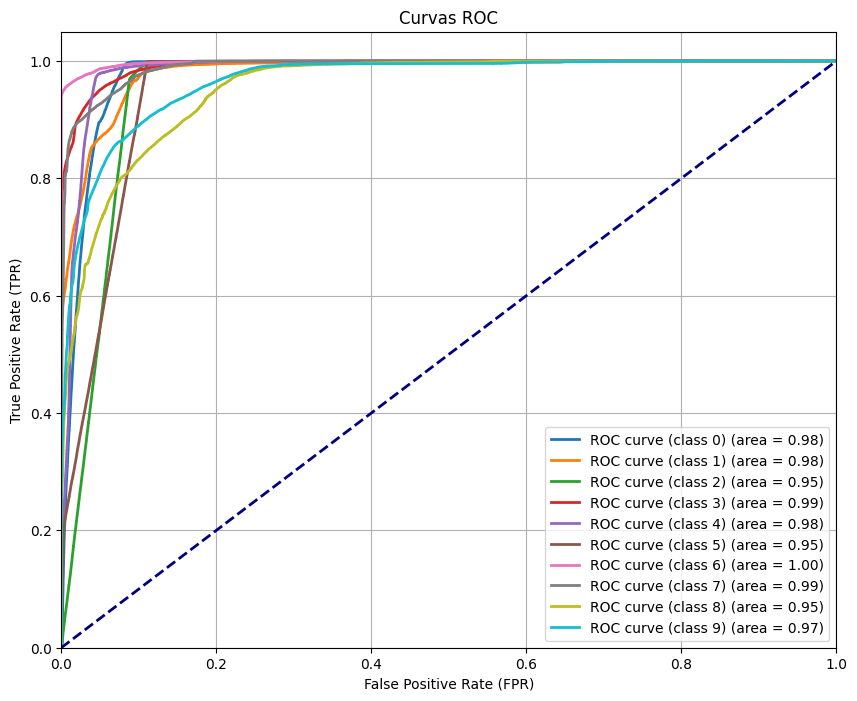

In [ ]:
classes = np.unique(y_test_encoded)
y_test_bin = label_binarize(y_test_encoded, classes=classes)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])  # Usar y_pred_proba en lugar de y_pred
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'ROC curve (class {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Para el perceptrón multicapa las curvas ROC sí son mejores que en el algoritmo SVM, aún así siguen sin ser mejores que las del sistema RF.

# SEGUNDO PERCEPTRÓN MULTICAPA (CON DROPOUT)
 Dropout consiste en desconectar neuronas con cada entrenamiento hasta conseguir el valor optimo. Es decir si se establece un valor de Dropout de un 20% se esta diciendo que en cada entrenamiento que se haga con la red neuronal se deshabilitará un 20% de las neuronas de esa capa.

In [ ]:
model_filepath = '/content/drive/My Drive/ProyectoPASM/Proyecto_balanceado/Model3/model3-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    #verbose = 1
)

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch = 50
steps_per_epoch = len(X_train) // batch
validation_steps = len(X_val) // batch

# Entrenar el modelo
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=40, batch_size=batch,
                    validation_data=(X_val, y_val_one_hot),
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks=[checkpoint])

Epoch 1/40
22356/22356 [==============================] - 66s 3ms/step - loss: 0.6997 - accuracy: 0.6812 - val_loss: 0.6312 - val_accuracy: 0.7174
Epoch 2/40
22356/22356 [==============================] - 64s 3ms/step - loss: 0.6298 - accuracy: 0.7137 - val_loss: 0.6037 - val_accuracy: 0.7265
Epoch 3/40
22356/22356 [==============================] - 65s 3ms/step - loss: 0.6088 - accuracy: 0.7232 - val_loss: 0.5849 - val_accuracy: 0.7355
Epoch 4/40
22356/22356 [==============================] - 64s 3ms/step - loss: 0.5976 - accuracy: 0.7286 - val_loss: 0.5768 - val_accuracy: 0.7380
Epoch 5/40
22356/22356 [==============================] - 65s 3ms/step - loss: 0.5903 - accuracy: 0.7324 - val_loss: 0.5745 - val_accuracy: 0.7415
Epoch 6/40
22356/22356 [==============================] - 64s 3ms/step - loss: 0.5833 - accuracy: 0.7355 - val_loss: 0.5706 - val_accuracy: 0.7412
Epoch 7/40
22356/22356 [==============================] - 64s 3ms/step - loss: 0.5802 - accuracy: 0.7373 - val_loss: 0

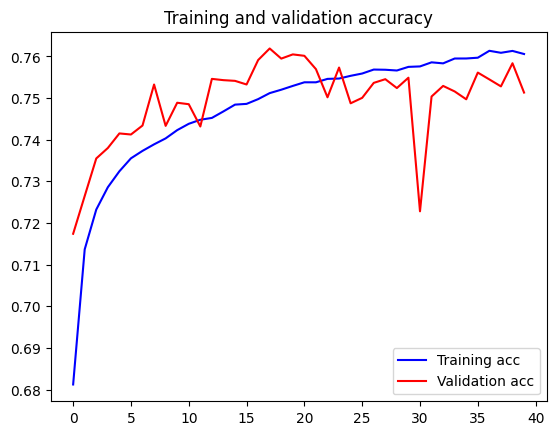

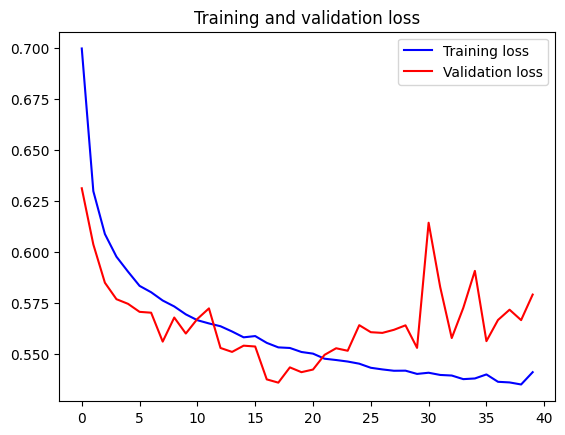

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Si se comparan estas gráficas con las del perceptrón multicapa sin dropout, aunque con dropout en el conjunto de entrenamiento no se ha obtenido una precisión tan alta, sucede que para el conjunton de validación no sufre cambios tan bruscos y por tanto consigue un valor de precisión más alto.

In [ ]:
#Importamos el modelo con mayor accuracy en validacion
MLP2 = load_model('/content/drive/My Drive/ProyectoPASM/Proyecto_balanceado/Model3/model3-18-0.7619.keras')

## MATRIZ DE CONFUSIÓN

In [ ]:
y_pred_score = MLP2.predict(X_test)
y_pred = np.argmax(y_pred_score, axis=1)

9982/9982 [==============================] - 16s 2ms/step


In [ ]:
# Calcular la precisión
accuracy = accuracy_score(y_test_encoded, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7526675015654352


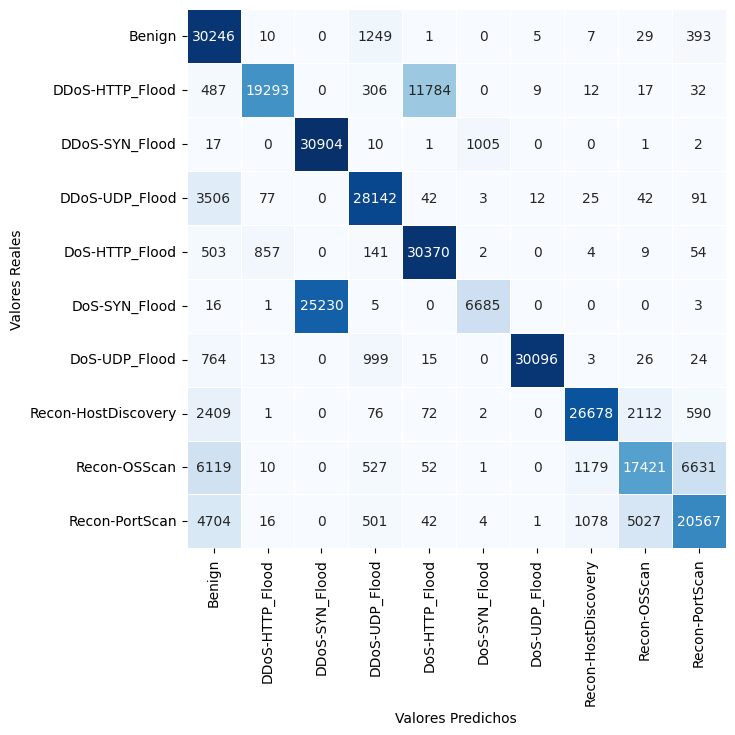

In [ ]:
cm = metrics.confusion_matrix(y_test_encoded, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

De igual manera que con el anterior perceptrón, no se obtienen unos buenos resultados de clasificación. El algoritmo RF sigue siendo superior.

## CURVAS FAR, FRR Y EER

In [ ]:
# Inicializar arrays para almacenar los scores genuinos e impostores
genuinos = []
impostores = []

# Iterar sobre cada dato de prueba
for i in range(len(y_test_encoded)):
    # Obtener la etiqueta real del dato actual
    etiqueta_real = y_test_encoded[i]

    # Obtener las probabilidades predichas para el dato actual
    prob_predicha = y_pred_score[i]

    # Obtener el score genuino para la clase real
    score_genuino = prob_predicha[etiqueta_real]


    scores_impostores = np.delete(prob_predicha, etiqueta_real)

    # Agregar los scores a los arrays correspondientes
    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)

# Convertir a arrays numpy para facilitar el manejo
genuinos = np.array(genuinos)
impostores = np.array(impostores)

# Verificar la forma de los arrays resultantes
print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)

Genuinos: (319400,)
Impostores: (2874600,)


In [ ]:
# Calcular la FAR y la FRR
thresholds = np.arange(0, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos < threshold) / len(genuinos))

# Imprimir FAR, FRR y AUC
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [1.0, 0.22742190217769429, 0.21499895637653935, 0.20572427468169485, 0.19764662909622208, 0.19120051485424058, 0.18587386071105544, 0.179536631183469, 0.1750212203437, 0.17213525360050094, 0.16954776316704934, 0.16708585542336324, 0.1641532734989216, 0.161326445418493, 0.1584209977040284, 0.15635079663257498, 0.15443400820983788, 0.15233562930494676, 0.1504136227649064, 0.1488631461768594, 0.14760105753844013, 0.1463034857023586, 0.1450723578932721, 0.14382174911292006, 0.14251895915953525, 0.14105858206359145, 0.13988868016419675, 0.13872121338621027, 0.13767828567452864, 0.13674841717108469, 0.13571314269811452, 0.13479371042927712, 0.1337925276560217, 0.1329266680581646, 0.1321432547136993, 0.13135079663257496, 0.13047136992972935, 0.12957281013010505, 0.12857719334863982, 0.1275436582481041, 0.12644820148890282, 0.12546023794614902, 0.12456898351074933, 0.12364885549293815, 0.1228379600640089, 0.12207576706324358, 0.12133931677450775, 0.12068670423711125, 0.11994573158004591, 

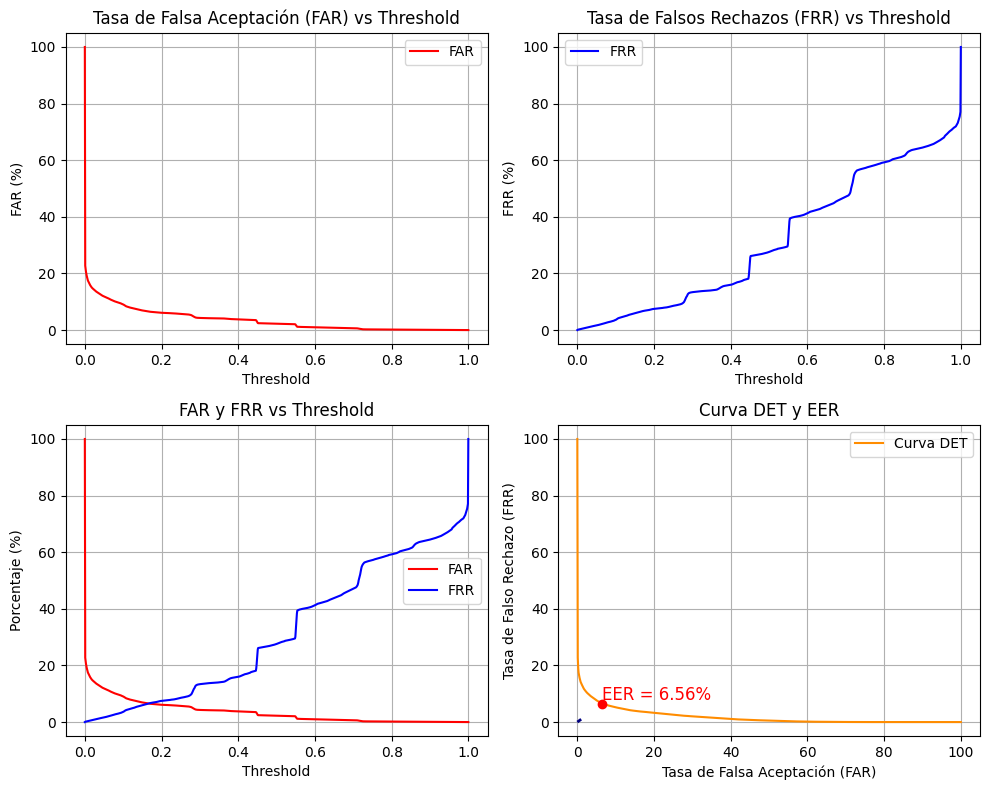

In [ ]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.absolute((np.array(FAR_porcentaje) - np.array(FRR_porcentaje))))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Graficar FAR vs Threshold
axs[0, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('FAR (%)')
axs[0, 0].set_title('Tasa de Falsa Aceptación (FAR) vs Threshold')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Graficar FRR vs Threshold
axs[0, 1].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[0, 1].set_xlabel('Threshold')
axs[0, 1].set_ylabel('FRR (%)')
axs[0, 1].set_title('Tasa de Falsos Rechazos (FRR) vs Threshold')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Graficar FAR y FRR juntas
axs[1, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[1, 0].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('Porcentaje (%)')
axs[1, 0].set_title('FAR y FRR vs Threshold')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Graficar Curva DET
axs[1, 1].plot(FRR_porcentaje, FAR_porcentaje, color='darkorange', label='Curva DET')
axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1, 1].scatter([eer], [eer], color='red', zorder=5)
axs[1, 1].text(eer, eer, f'EER = {eer:.2f}%', color='red', fontsize=12, verticalalignment='bottom')
axs[1, 1].set_xlabel('Tasa de Falsa Aceptación (FAR)')
axs[1, 1].set_ylabel('Tasa de Falso Rechazo (FRR)')
axs[1, 1].set_title('Curva DET y EER')
axs[1, 1].grid(True)
axs[1, 1].legend(loc="upper right")

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

## CURVAS ROC

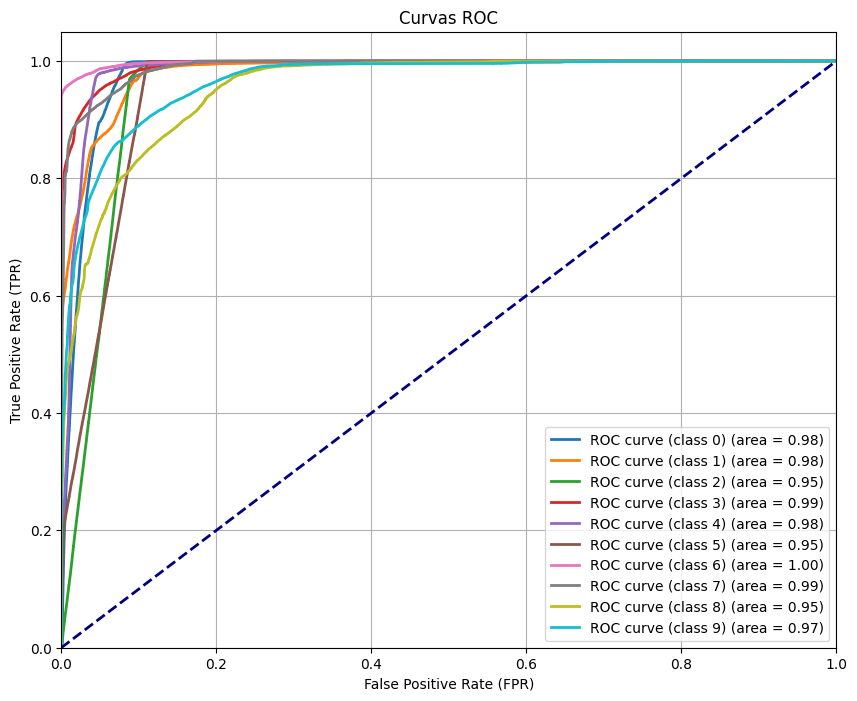

In [ ]:
classes = np.unique(y_test_encoded)
y_test_bin = label_binarize(y_test_encoded, classes=classes)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])  # Usar y_pred_proba en lugar de y_pred
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'ROC curve (class {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Las curvas ROC son prácticamente idénticas a las del perceptron multicapa sin dropout. El diagnóstico del rendimiento es, por tanto, similar entre los dos perceptrones.

# RED NEURONAL CONVOLUCIONAL:

Una CNN consta de una capa de entrada, una capa de salida y varias capas ocultas entre ambas. Estas capas realizan operaciones que modifican los datos, con el propósito de comprender sus características particulares.
Aunque en este caso los datos no presentan una clara relación espacial entre sus caracteríticas, se ha probado a implementar una red neuronal convolucional para comprobar si esta es capaz de ofrecer mejores resultados que los perceptrones multicapa anteriores.

In [ ]:
model_filepath = '/content/drive/My Drive/ProyectoPASM/Proyecto_balanceado/ModelCNN/modelCNN-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    #verbose = 1
)

In [ ]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(200, activation='relu'),
    Dense(10, activation = 'softmax')])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch = 50
steps_per_epoch = len(X_train) // batch
validation_steps = len(X_val) // batch

# Entrenar el modelo
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=20, batch_size=batch,
                    validation_data=(X_val, y_val_one_hot),
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks=[checkpoint])



Epoch 1/20
22356/22356 [==============================] - 318s 14ms/step - loss: 0.6270 - accuracy: 0.7165 - val_loss: 0.5782 - val_accuracy: 0.7399
Epoch 2/20
22356/22356 [==============================] - 296s 13ms/step - loss: 0.5382 - accuracy: 0.7544 - val_loss: 0.5417 - val_accuracy: 0.7574
Epoch 3/20
22356/22356 [==============================] - 301s 13ms/step - loss: 0.5135 - accuracy: 0.7653 - val_loss: 0.5445 - val_accuracy: 0.7612
Epoch 4/20
22356/22356 [==============================] - 295s 13ms/step - loss: 0.5002 - accuracy: 0.7722 - val_loss: 0.5268 - val_accuracy: 0.7695
Epoch 5/20
22356/22356 [==============================] - 295s 13ms/step - loss: 0.4912 - accuracy: 0.7764 - val_loss: 0.5357 - val_accuracy: 0.7630
Epoch 6/20
22356/22356 [==============================] - 297s 13ms/step - loss: 0.4858 - accuracy: 0.7798 - val_loss: 0.5346 - val_accuracy: 0.7670
Epoch 7/20
22356/22356 [==============================] - 304s 14ms/step - loss: 0.4796 - accuracy: 0.7810

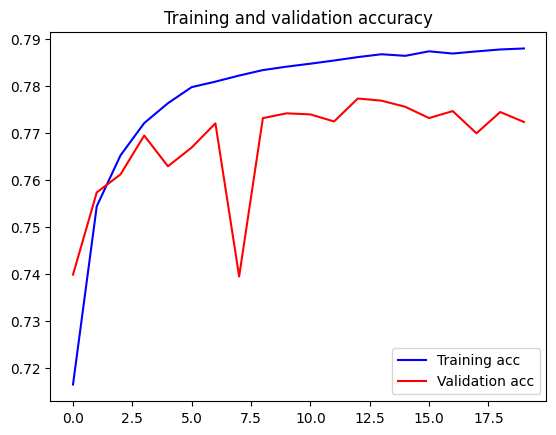

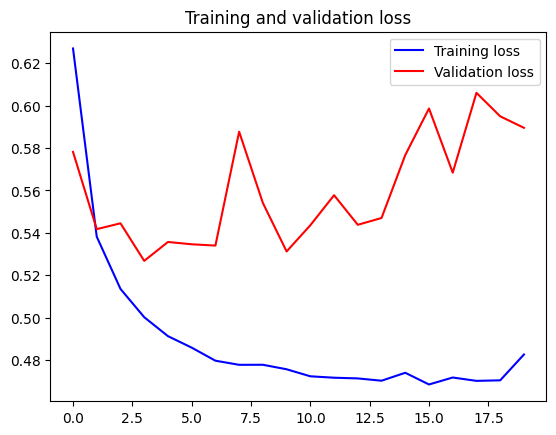

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Al comparar los resultados de entrenamiento y validación de la CNN con los de los perceptrones no se aprecian grandes diferencias.

In [ ]:
# Cargamos el modelo con mayor accuracy en validacion
CNN = load_model('/content/drive/My Drive/ProyectoPASM/Proyecto_balanceado/ModelCNN/modelCNN-13-0.7774.keras')

## MATRIZ DE CONFUSION

In [ ]:
y_pred_proba = CNN.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

9982/9982 [==============================] - 30s 3ms/step


In [ ]:
# Calcular la precisión
accuracy = accuracy_score(y_test_encoded, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7721039448966813


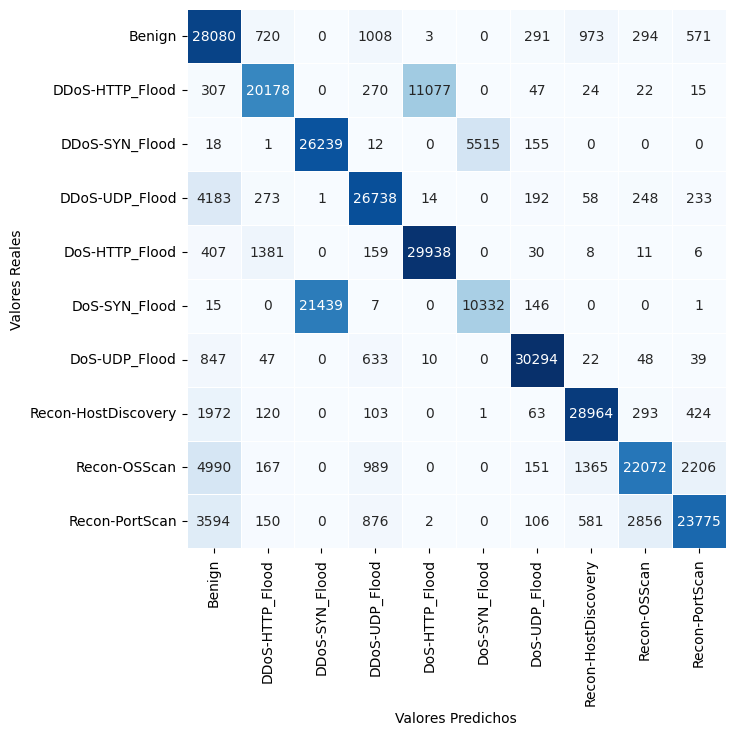

In [ ]:
cm = metrics.confusion_matrix(y_test_encoded, y_pred)
normalized_matrix = cm #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Los resultados de la matriz de confusión son los esperados, ya que al notar con las anteriores gráficas que su comportamiento es similar al de los perceptrones, se podía preveer que no se realizaría una gran clasificación.

## CURVAS FAR, FRR Y EER

In [ ]:
# Inicializar arrays para almacenar los scores genuinos e impostores
genuinos = []
impostores = []

# Iterar sobre cada dato de prueba
for i in range(len(y_test_encoded)):
    # Obtener la etiqueta real del dato actual
    etiqueta_real = y_test_encoded[i]

    # Obtener las probabilidades predichas para el dato actual
    prob_predicha = y_pred_proba[i]

    # Obtener el score genuino para la clase real
    score_genuino = prob_predicha[etiqueta_real]


    scores_impostores = np.delete(prob_predicha, etiqueta_real)

    # Agregar los scores a los arrays correspondientes
    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)

# Convertir a arrays numpy para facilitar el manejo
genuinos = np.array(genuinos)
impostores = np.array(impostores)

# Verificar la forma de los arrays resultantes
print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)

Genuinos: (319400,)
Impostores: (2874600,)


In [ ]:
# Calcular la FAR y la FRR
thresholds = np.arange(0, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos < threshold) / len(genuinos))

# Imprimir FAR, FRR y AUC
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [1.0, 0.1813807138384471, 0.16947401377582968, 0.16224413831489598, 0.15751165379531065, 0.15203123912892227, 0.1470983789048911, 0.14371495164544631, 0.14117825088707994, 0.13897864050650524, 0.1373119738398386, 0.1353183051554999, 0.13369616642315452, 0.13220448062339107, 0.13028038683642942, 0.1285632783691644, 0.12702462951367147, 0.125266471856954, 0.12395846378626592, 0.12287866137897446, 0.12198601544562722, 0.12118172963194879, 0.12042440687399986, 0.1197053503096083, 0.11900194809712655, 0.11830028525707925, 0.11756592221526473, 0.11685104014471578, 0.11609997912753078, 0.11536352883879496, 0.11462151255826898, 0.11396055103318722, 0.1132613233145481, 0.1126132331454811, 0.11196096848257149, 0.11137967021498643, 0.11079871982188827, 0.1102549919988868, 0.10967786822514437, 0.10901203645724622, 0.10840464760314479, 0.107798302372504, 0.1069418353857928, 0.10612224309469144, 0.10539275029569331, 0.1046747373547624, 0.10404369303555278, 0.10337542614624644, 0.102398594587072

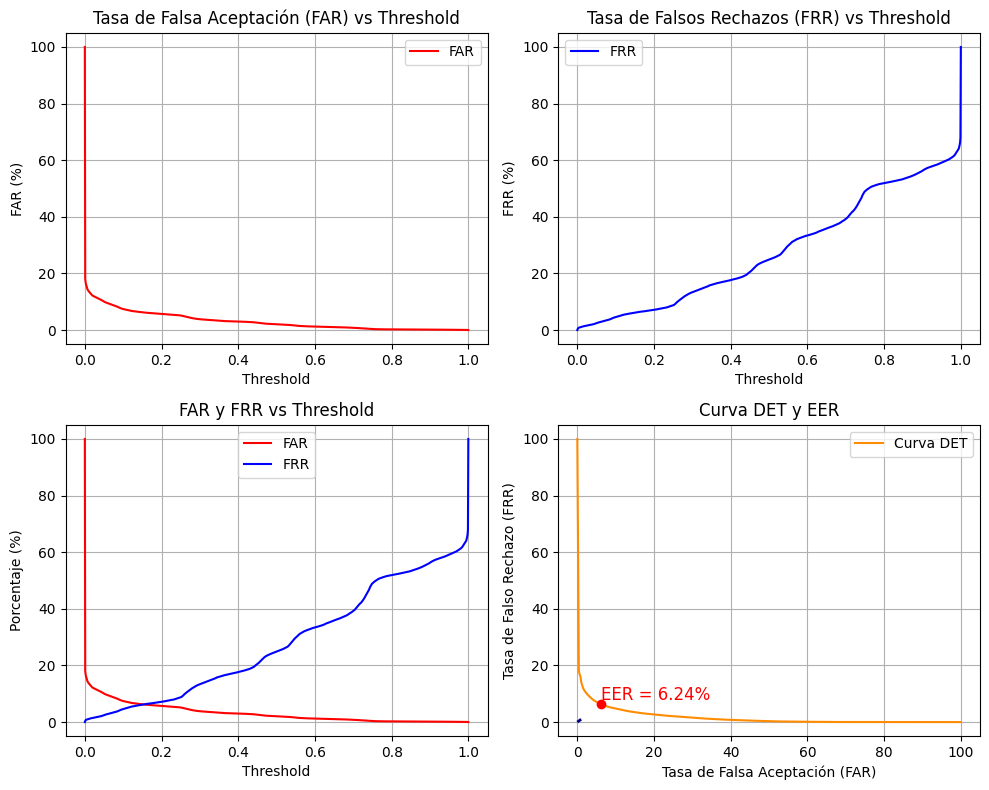

In [ ]:
FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.absolute((np.array(FAR_porcentaje) - np.array(FRR_porcentaje))))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Graficar FAR vs Threshold
axs[0, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('FAR (%)')
axs[0, 0].set_title('Tasa de Falsa Aceptación (FAR) vs Threshold')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Graficar FRR vs Threshold
axs[0, 1].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[0, 1].set_xlabel('Threshold')
axs[0, 1].set_ylabel('FRR (%)')
axs[0, 1].set_title('Tasa de Falsos Rechazos (FRR) vs Threshold')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Graficar FAR y FRR juntas
axs[1, 0].plot(thresholds, FAR_porcentaje, label='FAR', color='red')
axs[1, 0].plot(thresholds, FRR_porcentaje, label='FRR', color='blue')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('Porcentaje (%)')
axs[1, 0].set_title('FAR y FRR vs Threshold')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Graficar Curva DET
axs[1, 1].plot(FRR_porcentaje, FAR_porcentaje, color='darkorange', label='Curva DET')
axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1, 1].scatter([eer], [eer], color='red', zorder=5)
axs[1, 1].text(eer, eer, f'EER = {eer:.2f}%', color='red', fontsize=12, verticalalignment='bottom')
axs[1, 1].set_xlabel('Tasa de Falsa Aceptación (FAR)')
axs[1, 1].set_ylabel('Tasa de Falso Rechazo (FRR)')
axs[1, 1].set_title('Curva DET y EER')
axs[1, 1].grid(True)
axs[1, 1].legend(loc="upper right")

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

## CURVAS ROC

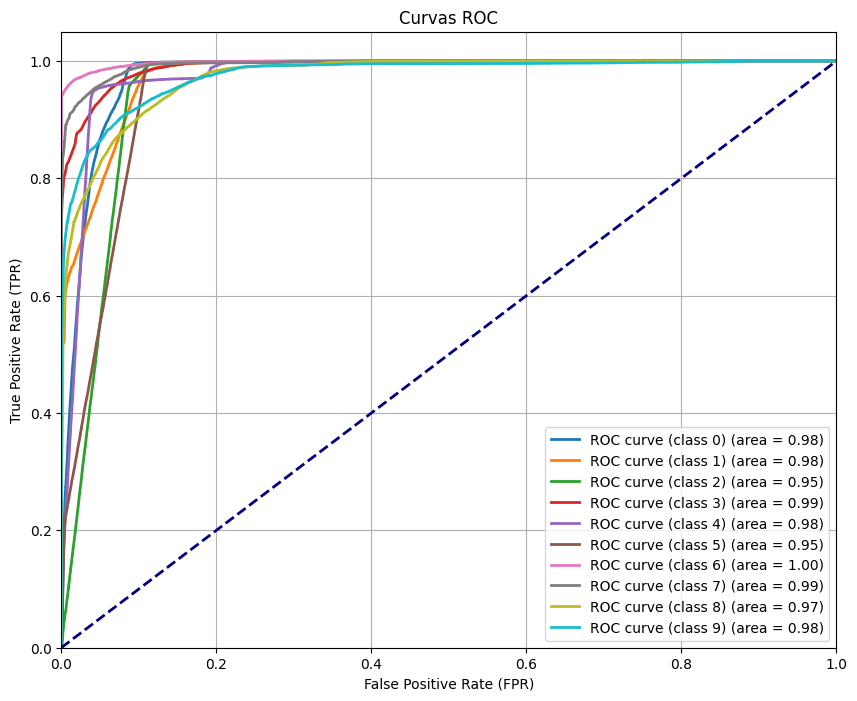

In [ ]:
classes = np.unique(y_test_encoded)
y_test_bin = label_binarize(y_test_encoded, classes=classes)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])  # Usar y_pred_proba en lugar de y_pred
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'ROC curve (class {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Las curvas ROC de la CNN también son prácticamente idénticas que a las de los perceptrones y, por tanto, se concluye en el mismo resultado.

# CONCLUSIÓN
Tras analizar nuestro conjunto de datos y procesarlo de tal forma que se óptimice el rendimiento de los distintos algoritmos de clasificación que se han aplicado a lo largo de este proyecto, se ha llegado a la conclusión de que por la forma de los datos los mejores resultados se han obtenido mediante el algoritmo Random Forest.
